In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

# Load Data

In [50]:
# Read pickle data
file_path = "vs_profiles.pkl"

with open(file_path, "rb") as f:
    data = pickle.load(f)

# Extract the data from dictionary
Vs_data_array = []

for key in data.keys():
    Vs_data_array.append(data[key][1])

In [51]:
from torch.nn.utils.rnn import pad_sequence
# Find the maximum length of the Vs data
max_length = max(len(vs_data) for vs_data in Vs_data_array)
print(f"Maximum length of Vs data: {max_length}")

# Pad the sequences to the maximum length
Vs_data_padded = pad_sequence([torch.tensor(vs_data,dtype=torch.float32) for vs_data in Vs_data_array], batch_first=True, padding_value=0.0)

Maximum length of Vs data: 4519


In [52]:
# Check Nans in the data
print(f"Number of NaNs in Vs_data_padded: {torch.isnan(Vs_data_padded).sum().item()}")

Number of NaNs in Vs_data_padded: 0


In [53]:
class Vs_data(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
# Create a dataset and dataloader
dataset = Vs_data(Vs_data_padded)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
batch_size = 32

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print the sizes of the datasets
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Training set size: 1895
Validation set size: 236
Test set size: 238


# Model

In [54]:
# --- Configuration ---
INPUT_DIM = max_length      # Dimension of your 1D array (must be fixed for this basic GAN)
LATENT_DIM = 64      # Dimension of the latent noise vector
HIDDEN_DIM_G = 128   # Hidden dimension for the Generator
HIDDEN_DIM_D = 128   # Hidden dimension for the Discriminator
BATCH_SIZE = 64
LR_G = 0.0002        # Learning rate for Generator
LR_D = 0.0002        # Learning rate for Discriminator
EPOCHS = 200
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Generator ---
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2), # LeakyReLU is common in GANs
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, output_dim),
            # No activation here if output is potentially unbounded.
            # Use nn.Sigmoid() if your 1D data is normalized between 0 and 1.
        )

    def forward(self, z):
        return self.main(z)

# --- Discriminator ---
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid() # Output a probability between 0 and 1
        )

    def forward(self, x):
        return self.main(x)

# --- Initialize Models, Loss Function, and Optimizers ---
generator = Generator(LATENT_DIM, HIDDEN_DIM_G, INPUT_DIM).to(device)
discriminator = Discriminator(INPUT_DIM, HIDDEN_DIM_D).to(device)

# Binary Cross-Entropy loss is standard for the basic GAN formulation
criterion = nn.BCEWithLogitsLoss() # Combines Sigmoid and BCELoss for stability

# Optimizers for each network
optimizer_G = optim.Adam(generator.parameters(), lr=LR_G, betas=(0.5, 0.999)) # Betas are often adjusted for GANs
optimizer_D = optim.Adam(discriminator.parameters(), lr=LR_D, betas=(0.5, 0.999))

print("Generator and Discriminator initialized.")

Using device: cuda
Generator and Discriminator initialized.


In [55]:
# Check if the models work with X, y data
X = next(iter(train_loader))[0].to(device)
y = torch.ones(X.size(0), 1).to(device) # Fake labels for generator

fake_data = generator(torch.randn(X.size(0), LATENT_DIM).to(device))
print(f"Fake data shape: {fake_data.shape}")
print(f"Discriminator output shape: {discriminator(fake_data).shape}")



Fake data shape: torch.Size([4519, 4519])
Discriminator output shape: torch.Size([4519, 1])


Starting training with validation and periodic sample generation...
Epoch [1/200], Train Loss D: 1.2734, Train Loss G: 0.4914, Val Loss D: 1.2880, Val Loss G: 0.4741
Epoch [2/200], Train Loss D: 1.2839, Train Loss G: 0.4855, Val Loss D: 1.2776, Val Loss G: 0.4866
Epoch [3/200], Train Loss D: 1.2570, Train Loss G: 0.5014, Val Loss D: 1.2522, Val Loss G: 0.5064
Epoch [4/200], Train Loss D: 1.2375, Train Loss G: 0.5208, Val Loss D: 1.2219, Val Loss G: 0.5162
Epoch [5/200], Train Loss D: 1.2021, Train Loss G: 0.5500, Val Loss D: 1.1860, Val Loss G: 0.5476
Epoch [6/200], Train Loss D: 1.1691, Train Loss G: 0.5868, Val Loss D: 1.1460, Val Loss G: 0.6253
Epoch [7/200], Train Loss D: 1.1393, Train Loss G: 0.6234, Val Loss D: 1.1937, Val Loss G: 0.5411
Epoch [8/200], Train Loss D: 1.1172, Train Loss G: 0.6338, Val Loss D: 1.0654, Val Loss G: 0.6528
Epoch [9/200], Train Loss D: 1.0962, Train Loss G: 0.6531, Val Loss D: 1.1208, Val Loss G: 0.6326
Epoch [10/200], Train Loss D: 1.4323, Train Loss G

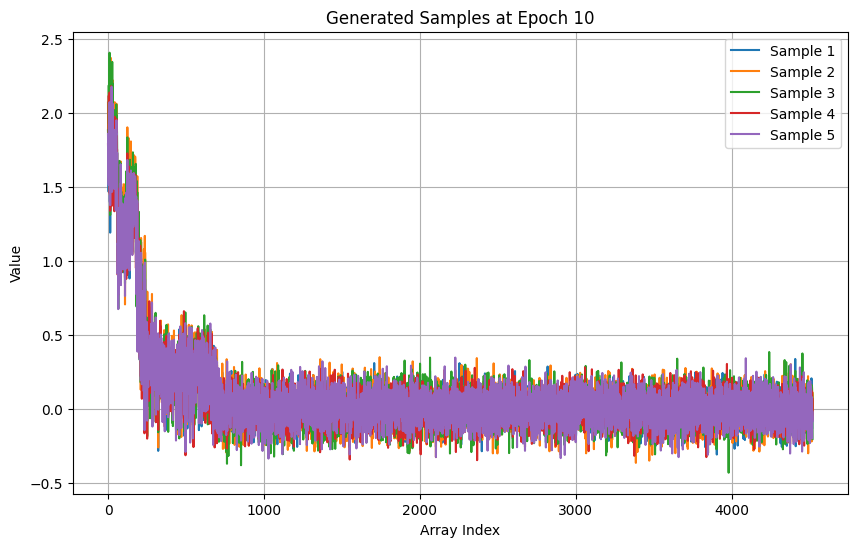

Epoch [11/200], Train Loss D: 1.3089, Train Loss G: 0.5697, Val Loss D: 1.1157, Val Loss G: 0.6839
Epoch [12/200], Train Loss D: 1.1213, Train Loss G: 0.6855, Val Loss D: 1.1084, Val Loss G: 0.6867
Epoch [13/200], Train Loss D: 1.1199, Train Loss G: 0.6879, Val Loss D: 1.1115, Val Loss G: 0.6881
Epoch [14/200], Train Loss D: 1.1172, Train Loss G: 0.6861, Val Loss D: 1.1088, Val Loss G: 0.6848
Epoch [15/200], Train Loss D: 1.1207, Train Loss G: 0.6798, Val Loss D: 1.1317, Val Loss G: 0.6629
Epoch [16/200], Train Loss D: 1.1534, Train Loss G: 0.6636, Val Loss D: 1.1680, Val Loss G: 0.6530
Epoch [17/200], Train Loss D: 1.1445, Train Loss G: 0.6724, Val Loss D: 1.1160, Val Loss G: 0.6715
Epoch [18/200], Train Loss D: 1.0994, Train Loss G: 0.6780, Val Loss D: 1.1276, Val Loss G: 0.6250
Epoch [19/200], Train Loss D: 1.0654, Train Loss G: 0.6845, Val Loss D: 1.0690, Val Loss G: 0.6866
Epoch [20/200], Train Loss D: 1.0635, Train Loss G: 0.6849, Val Loss D: 1.0977, Val Loss G: 0.6584

Generatin

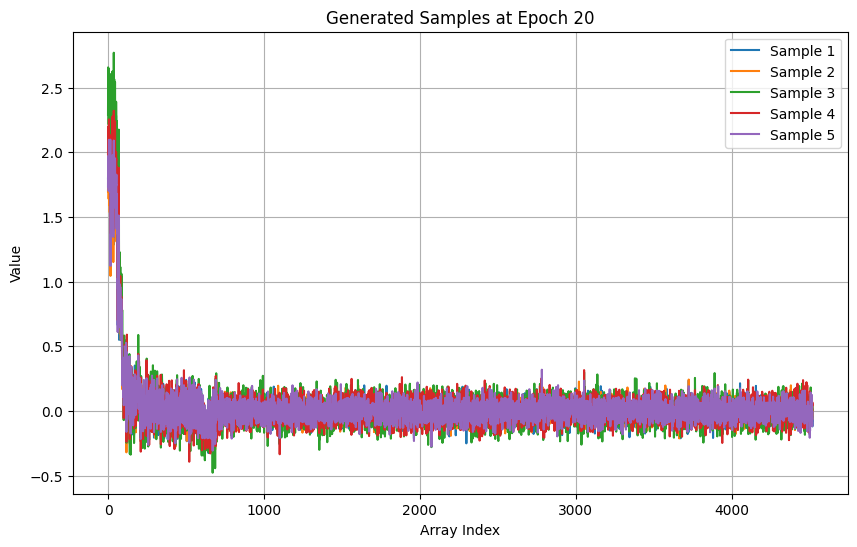

Epoch [21/200], Train Loss D: 1.2448, Train Loss G: 0.5790, Val Loss D: 1.6597, Val Loss G: 0.3142
Epoch [22/200], Train Loss D: 1.6540, Train Loss G: 0.3175, Val Loss D: 1.6519, Val Loss G: 0.3225
Epoch [23/200], Train Loss D: 1.6634, Train Loss G: 0.3206, Val Loss D: 1.6734, Val Loss G: 0.3172
Epoch [24/200], Train Loss D: 1.6543, Train Loss G: 0.3145, Val Loss D: 1.6536, Val Loss G: 0.3133
Epoch [25/200], Train Loss D: 1.6523, Train Loss G: 0.3133, Val Loss D: 1.6536, Val Loss G: 0.3133
Epoch [26/200], Train Loss D: 1.6530, Train Loss G: 0.3133, Val Loss D: 1.6535, Val Loss G: 0.3133
Epoch [27/200], Train Loss D: 1.6529, Train Loss G: 0.3133, Val Loss D: 1.6535, Val Loss G: 0.3134
Epoch [28/200], Train Loss D: 1.6495, Train Loss G: 0.3134, Val Loss D: 1.6392, Val Loss G: 0.3133
Epoch [29/200], Train Loss D: 1.6371, Train Loss G: 0.3133, Val Loss D: 1.6393, Val Loss G: 0.3133
Epoch [30/200], Train Loss D: 1.6357, Train Loss G: 0.3134, Val Loss D: 1.6268, Val Loss G: 0.3134

Generatin

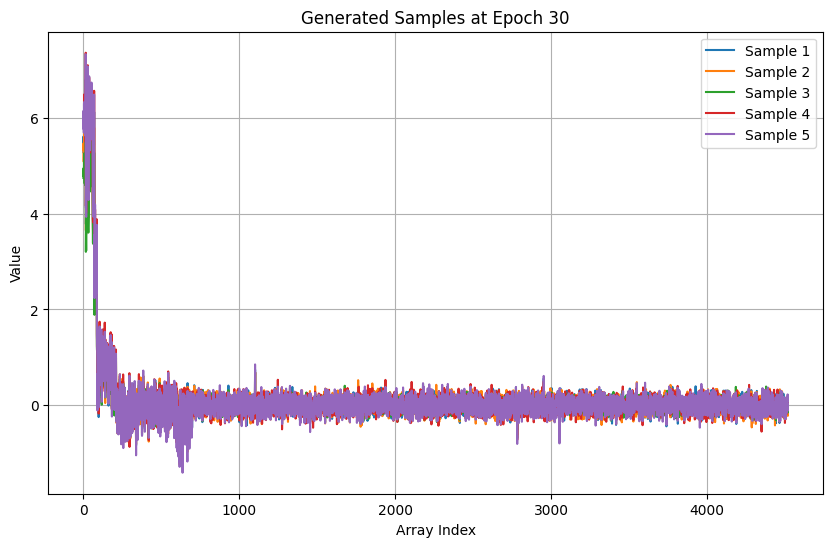

Epoch [31/200], Train Loss D: 1.6261, Train Loss G: 0.3134, Val Loss D: 1.6271, Val Loss G: 0.3134
Epoch [32/200], Train Loss D: 1.6266, Train Loss G: 0.3134, Val Loss D: 1.6266, Val Loss G: 0.3133
Epoch [33/200], Train Loss D: 1.6264, Train Loss G: 0.3133, Val Loss D: 1.6267, Val Loss G: 0.3133
Epoch [34/200], Train Loss D: 1.6264, Train Loss G: 0.3133, Val Loss D: 1.6268, Val Loss G: 0.3133
Epoch [35/200], Train Loss D: 1.6264, Train Loss G: 0.3133, Val Loss D: 1.6269, Val Loss G: 0.3133
Epoch [36/200], Train Loss D: 1.6264, Train Loss G: 0.3133, Val Loss D: 1.6270, Val Loss G: 0.3133
Epoch [37/200], Train Loss D: 1.6264, Train Loss G: 0.3133, Val Loss D: 1.6271, Val Loss G: 0.3133
Epoch [38/200], Train Loss D: 1.6264, Train Loss G: 0.3133, Val Loss D: 1.6272, Val Loss G: 0.3133
Epoch [39/200], Train Loss D: 1.6264, Train Loss G: 0.3133, Val Loss D: 1.6273, Val Loss G: 0.3133
Epoch [40/200], Train Loss D: 1.6264, Train Loss G: 0.3133, Val Loss D: 1.6273, Val Loss G: 0.3133

Generatin

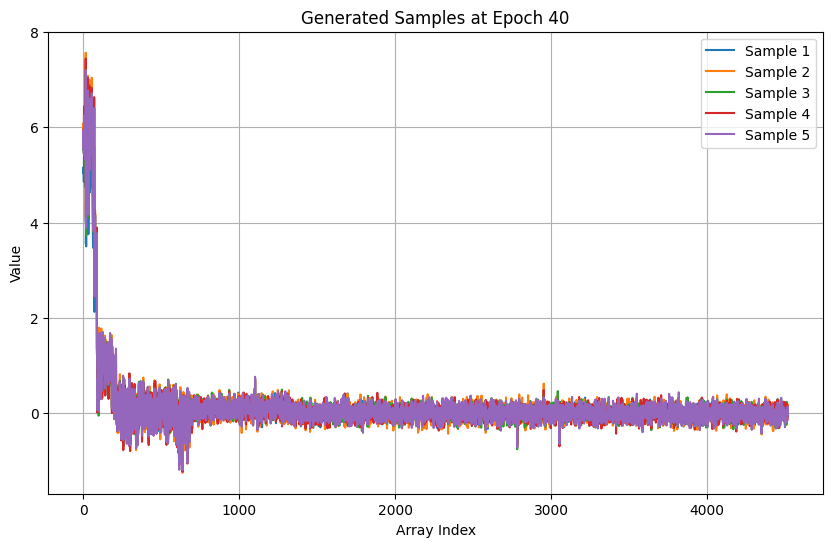

Epoch [41/200], Train Loss D: 1.6264, Train Loss G: 0.3133, Val Loss D: 1.6275, Val Loss G: 0.3133
Epoch [42/200], Train Loss D: 1.6264, Train Loss G: 0.3133, Val Loss D: 1.6275, Val Loss G: 0.3133
Epoch [43/200], Train Loss D: 1.6264, Train Loss G: 0.3133, Val Loss D: 1.6275, Val Loss G: 0.3133
Epoch [44/200], Train Loss D: 1.6264, Train Loss G: 0.3133, Val Loss D: 1.6276, Val Loss G: 0.3133
Epoch [45/200], Train Loss D: 1.6264, Train Loss G: 0.3133, Val Loss D: 1.6276, Val Loss G: 0.3133
Epoch [46/200], Train Loss D: 1.6264, Train Loss G: 0.3133, Val Loss D: 1.6276, Val Loss G: 0.3133
Epoch [47/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6276, Val Loss G: 0.3133
Epoch [48/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6276, Val Loss G: 0.3133
Epoch [49/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6276, Val Loss G: 0.3133
Epoch [50/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6276, Val Loss G: 0.3133

Generatin

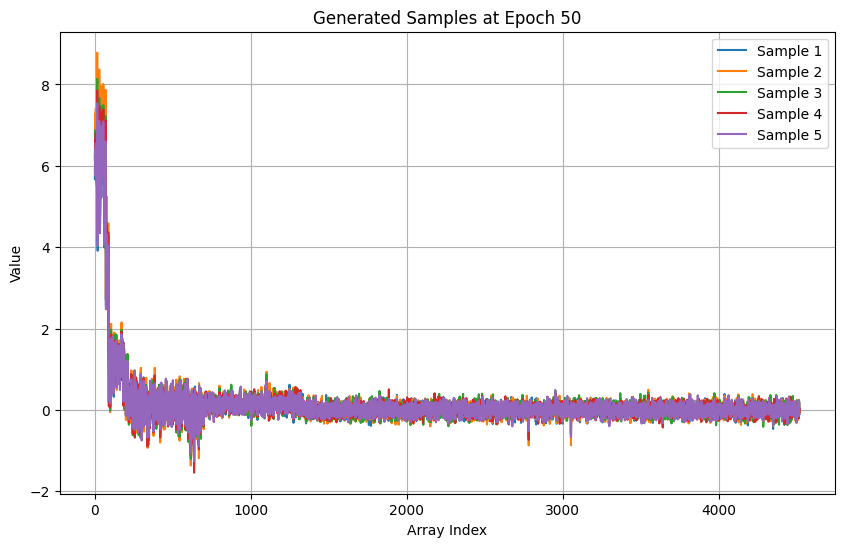

Epoch [51/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6276, Val Loss G: 0.3133
Epoch [52/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6276, Val Loss G: 0.3133
Epoch [53/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6276, Val Loss G: 0.3133
Epoch [54/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6276, Val Loss G: 0.3133
Epoch [55/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6277, Val Loss G: 0.3133
Epoch [56/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6277, Val Loss G: 0.3133
Epoch [57/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6276, Val Loss G: 0.3133
Epoch [58/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6276, Val Loss G: 0.3133
Epoch [59/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6277, Val Loss G: 0.3133
Epoch [60/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6276, Val Loss G: 0.3133

Generatin

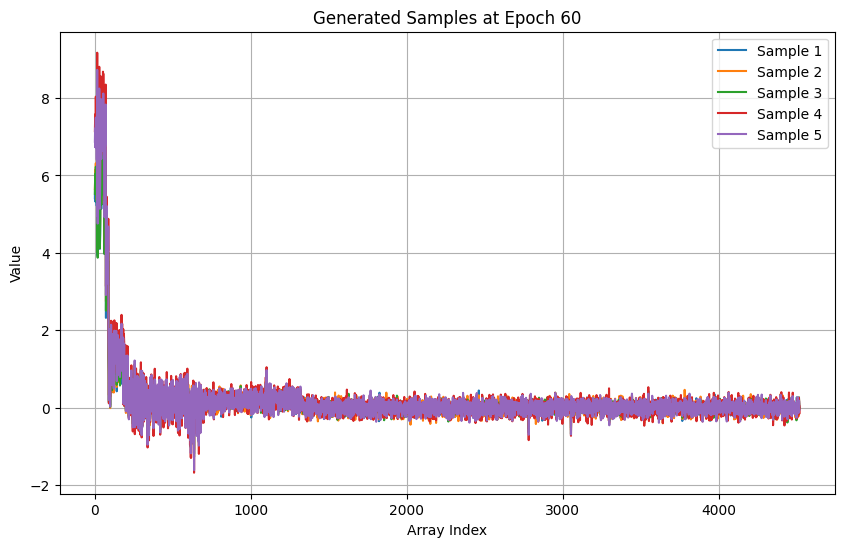

Epoch [61/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6276, Val Loss G: 0.3133
Epoch [62/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6276, Val Loss G: 0.3133
Epoch [63/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6276, Val Loss G: 0.3133
Epoch [64/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6276, Val Loss G: 0.3133
Epoch [65/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6276, Val Loss G: 0.3133
Epoch [66/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6276, Val Loss G: 0.3133
Epoch [67/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6276, Val Loss G: 0.3133
Epoch [68/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6276, Val Loss G: 0.3133
Epoch [69/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6276, Val Loss G: 0.3133
Epoch [70/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6276, Val Loss G: 0.3133

Generatin

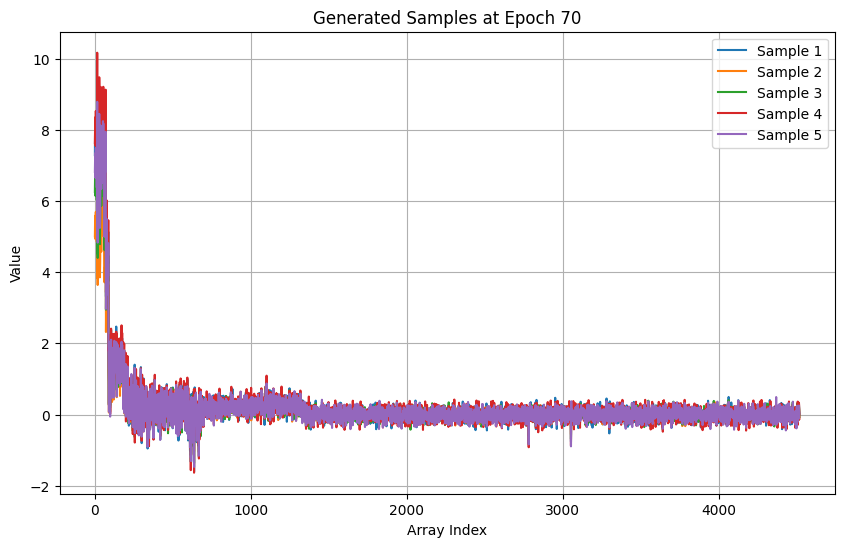

Epoch [71/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6276, Val Loss G: 0.3133
Epoch [72/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6276, Val Loss G: 0.3133
Epoch [73/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6276, Val Loss G: 0.3133
Epoch [74/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6276, Val Loss G: 0.3133
Epoch [75/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6284, Val Loss G: 0.3133
Epoch [76/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6290, Val Loss G: 0.3133
Epoch [77/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6291, Val Loss G: 0.3133
Epoch [78/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6291, Val Loss G: 0.3133
Epoch [79/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6291, Val Loss G: 0.3133
Epoch [80/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6290, Val Loss G: 0.3133

Generatin

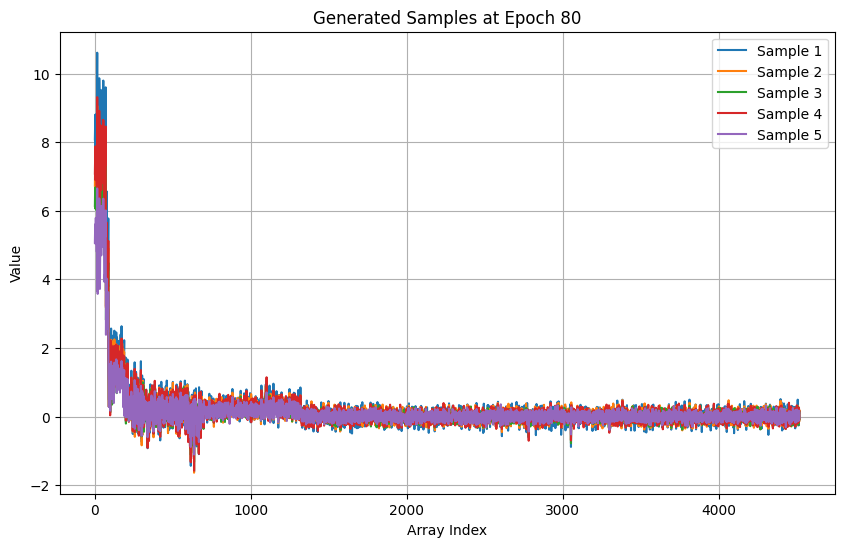

Epoch [81/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6290, Val Loss G: 0.3133
Epoch [82/200], Train Loss D: 1.6264, Train Loss G: 0.3133, Val Loss D: 1.6290, Val Loss G: 0.3133
Epoch [83/200], Train Loss D: 1.6263, Train Loss G: 0.3134, Val Loss D: 1.6269, Val Loss G: 0.3133
Epoch [84/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6269, Val Loss G: 0.3133
Epoch [85/200], Train Loss D: 1.6318, Train Loss G: 0.3135, Val Loss D: 1.6378, Val Loss G: 0.3133
Epoch [86/200], Train Loss D: 1.6396, Train Loss G: 0.3138, Val Loss D: 1.6448, Val Loss G: 0.3133
Epoch [87/200], Train Loss D: 1.6445, Train Loss G: 0.3133, Val Loss D: 1.6517, Val Loss G: 0.3133
Epoch [88/200], Train Loss D: 1.6455, Train Loss G: 0.3138, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [89/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [90/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133

Generatin

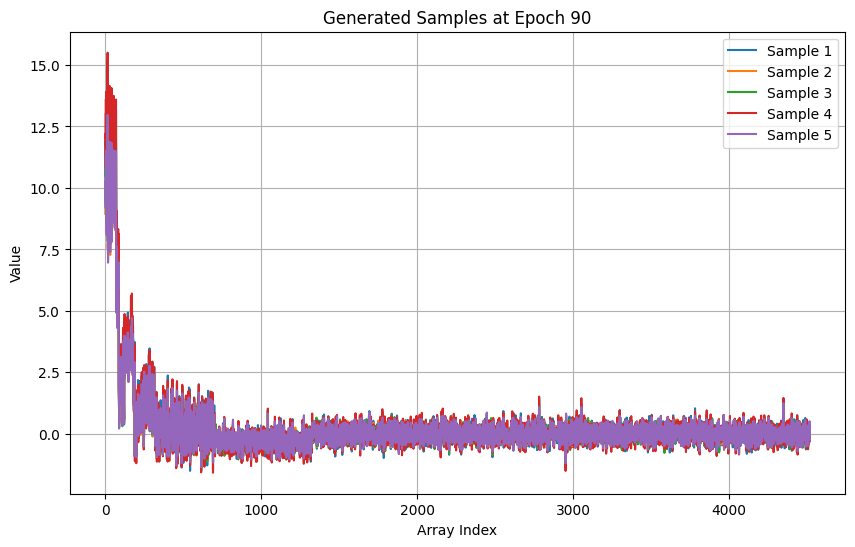

Epoch [91/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [92/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [93/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [94/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [95/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [96/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [97/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [98/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [99/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [100/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133

Generati

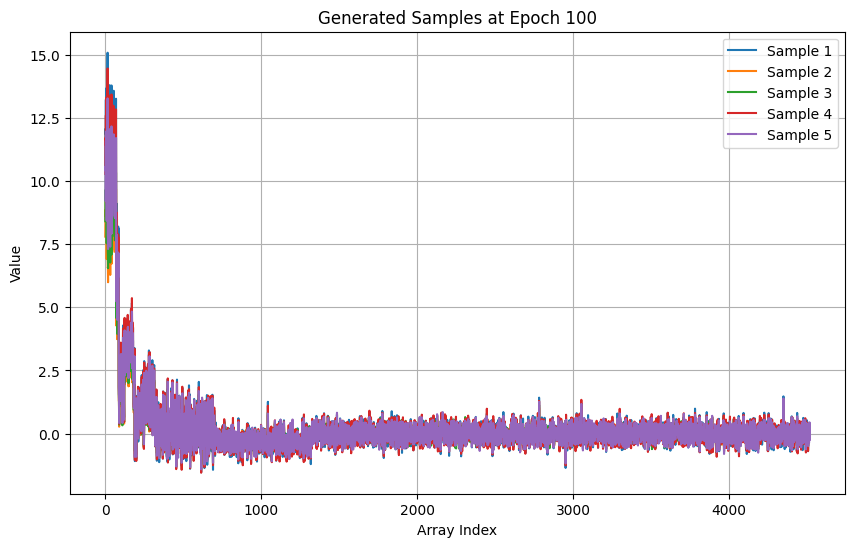

Epoch [101/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [102/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [103/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [104/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [105/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [106/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [107/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [108/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [109/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [110/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133


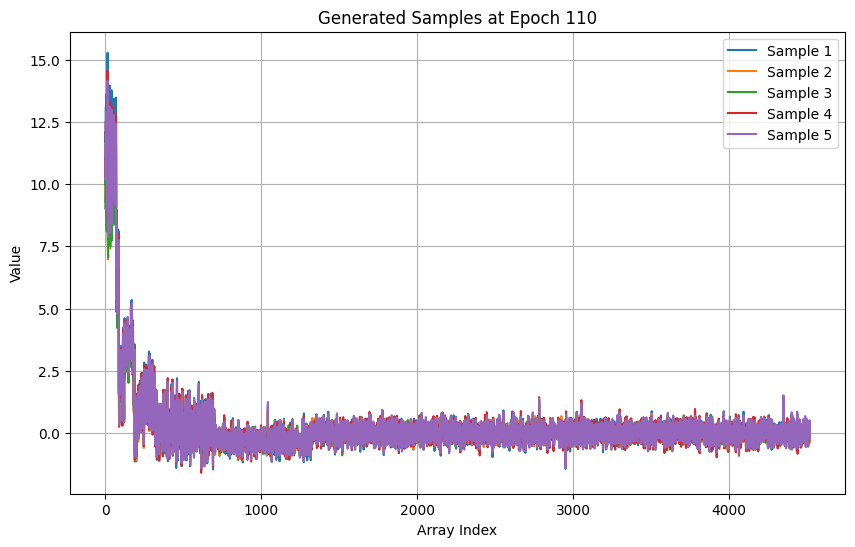

Epoch [111/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [112/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [113/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [114/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [115/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [116/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [117/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [118/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [119/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [120/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133


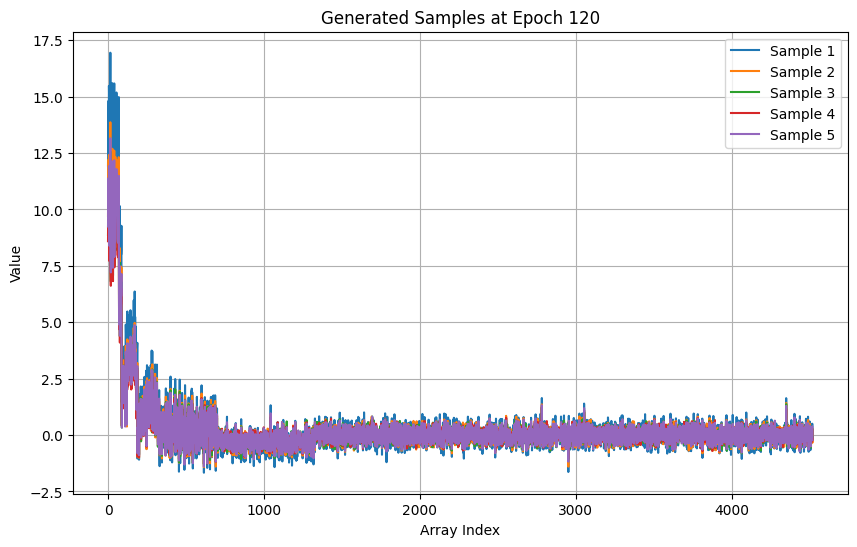

Epoch [121/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [122/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [123/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [124/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [125/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [126/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [127/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [128/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [129/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [130/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133


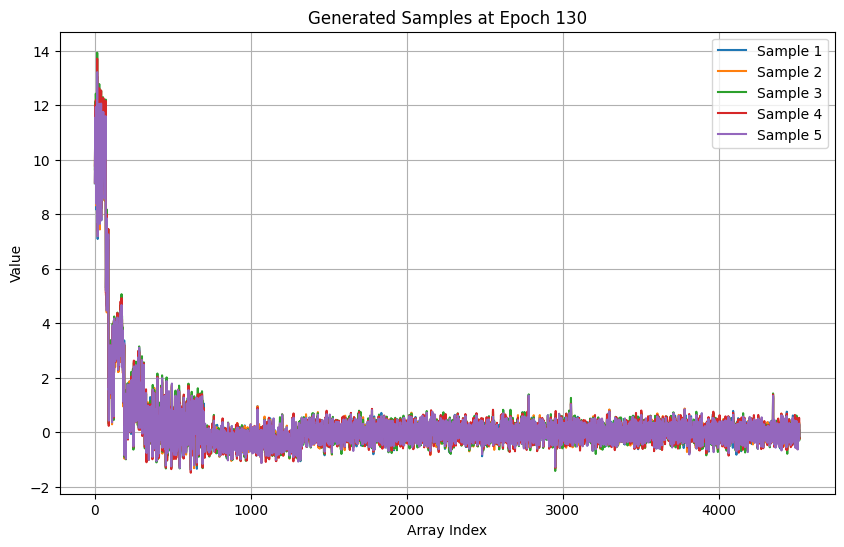

Epoch [131/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [132/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [133/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [134/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [135/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [136/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [137/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [138/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [139/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [140/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133


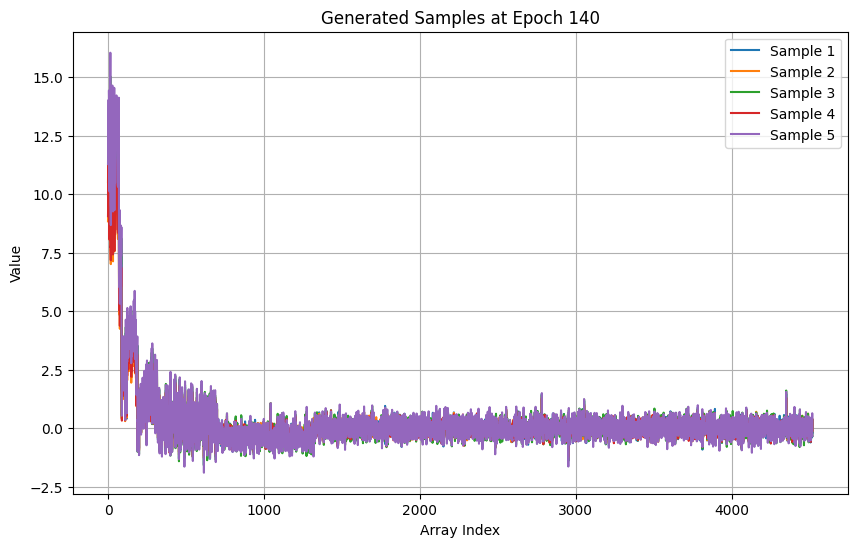

Epoch [141/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [142/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [143/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [144/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [145/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [146/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [147/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [148/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [149/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [150/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133


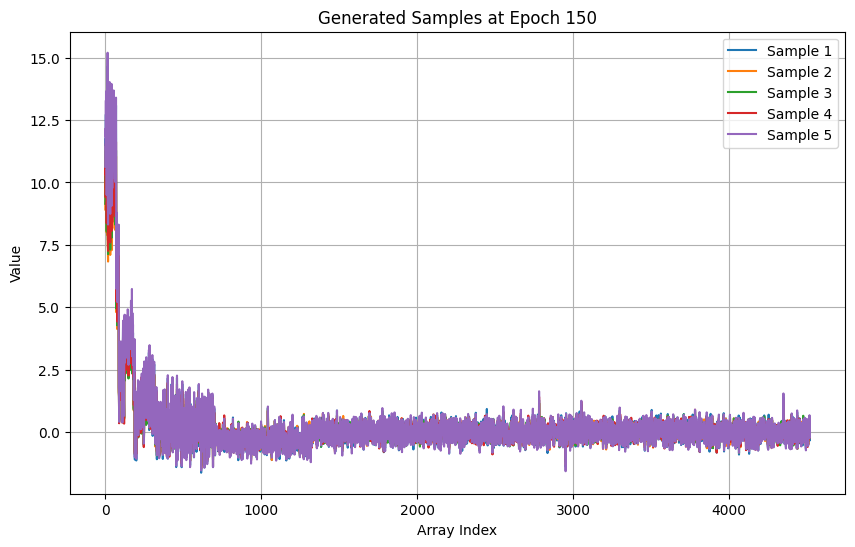

Epoch [151/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [152/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [153/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [154/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [155/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [156/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [157/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [158/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [159/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [160/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133


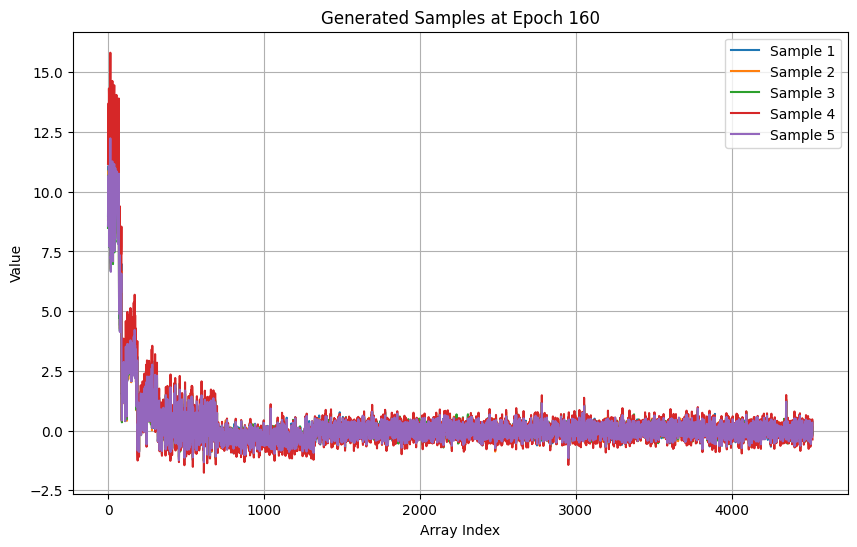

Epoch [161/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [162/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [163/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [164/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [165/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [166/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [167/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [168/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [169/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [170/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133


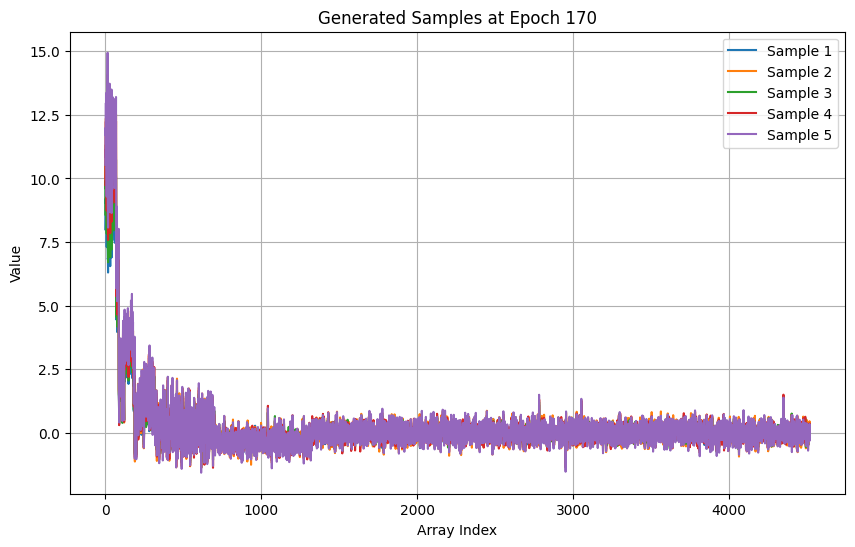

Epoch [171/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [172/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [173/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [174/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [175/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [176/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [177/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [178/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [179/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [180/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133


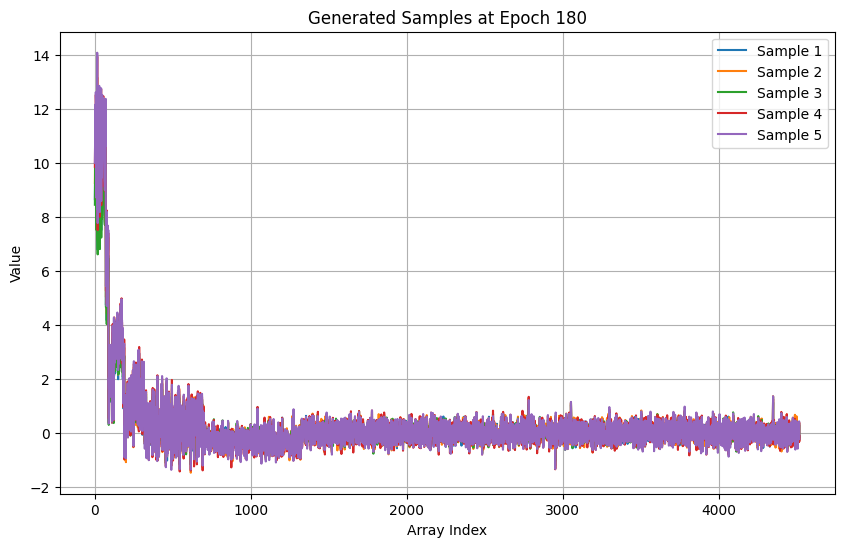

Epoch [181/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [182/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [183/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [184/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [185/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [186/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [187/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [188/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [189/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [190/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133


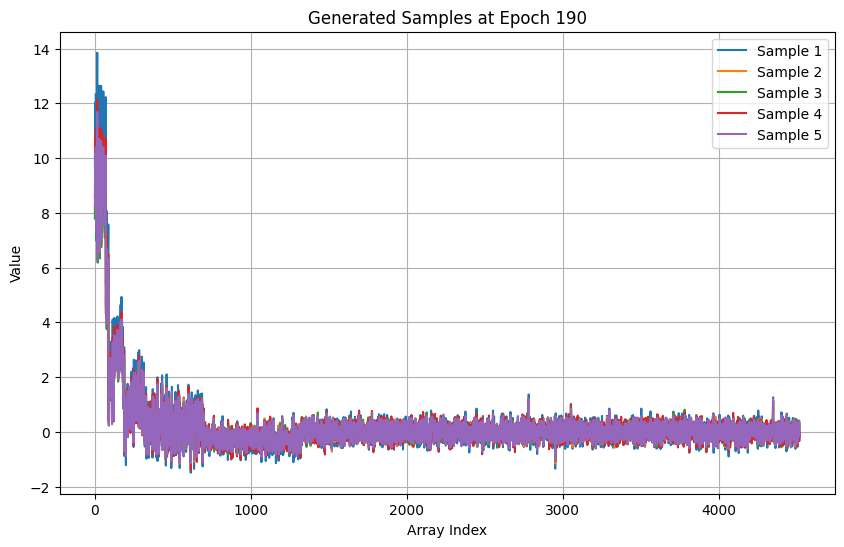

Epoch [191/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [192/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [193/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [194/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [195/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [196/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [197/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [198/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [199/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133
Epoch [200/200], Train Loss D: 1.6265, Train Loss G: 0.3133, Val Loss D: 1.6265, Val Loss G: 0.3133


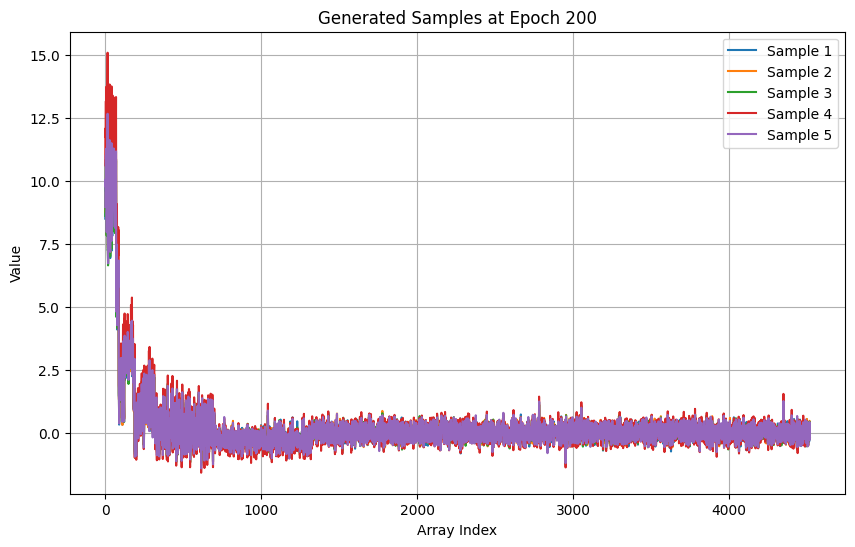

Training with validation and periodic sample generation finished.


In [56]:
# --- Training Loop with Periodic Sample Generation ---
print("Starting training with validation and periodic sample generation...")

# Store losses for analysis
train_losses_G = []
train_losses_D = []
val_losses_G = []
val_losses_D = []

for epoch in range(EPOCHS):
    # Training phase
    generator.train()
    discriminator.train()
    total_loss_G = 0
    total_loss_D = 0

    for i, real_data in enumerate(train_loader):
        real_data = real_data.to(device)
        b_size = real_data.size(0)

        # Create labels for real and fake data
        real_labels = torch.ones(b_size, 1).to(device)
        fake_labels = torch.zeros(b_size, 1).to(device)

        # --- Train Discriminator ---
        optimizer_D.zero_grad()

        # Train with real data
        output_real = discriminator(real_data)
        loss_D_real = criterion(output_real, real_labels)

        # Train with fake data
        noise = torch.randn(b_size, LATENT_DIM).to(device)
        fake_data = generator(noise).detach()
        output_fake = discriminator(fake_data)
        loss_D_fake = criterion(output_fake, fake_labels)

        # Total Discriminator loss
        loss_D = loss_D_real + loss_D_fake
        loss_D.backward()
        optimizer_D.step()

        # --- Train Generator ---
        optimizer_G.zero_grad()

        noise = torch.randn(b_size, LATENT_DIM).to(device)
        fake_data = generator(noise)
        output_fake_for_G = discriminator(fake_data)
        loss_G = criterion(output_fake_for_G, real_labels)
        loss_G.backward()
        optimizer_G.step()

        # Accumulate losses
        total_loss_D += loss_D.item()
        total_loss_G += loss_G.item()

    # Average losses for the epoch
    avg_loss_D = total_loss_D / len(train_loader)
    avg_loss_G = total_loss_G / len(train_loader)
    train_losses_D.append(avg_loss_D)
    train_losses_G.append(avg_loss_G)

    # Validation phase
    generator.eval()
    discriminator.eval()
    total_val_loss_G = 0
    total_val_loss_D = 0

    with torch.no_grad():
        for real_data in val_loader:
            real_data = real_data.to(device)
            b_size = real_data.size(0)

            # Create labels for real and fake data
            real_labels = torch.ones(b_size, 1).to(device)
            fake_labels = torch.zeros(b_size, 1).to(device)

            # Validation for Discriminator
            output_real = discriminator(real_data)
            loss_D_real = criterion(output_real, real_labels)

            noise = torch.randn(b_size, LATENT_DIM).to(device)
            fake_data = generator(noise)
            output_fake = discriminator(fake_data)
            loss_D_fake = criterion(output_fake, fake_labels)

            loss_D = loss_D_real + loss_D_fake
            total_val_loss_D += loss_D.item()

            # Validation for Generator
            output_fake_for_G = discriminator(fake_data)
            loss_G = criterion(output_fake_for_G, real_labels)
            total_val_loss_G += loss_G.item()

    # Average validation losses
    avg_val_loss_D = total_val_loss_D / len(val_loader)
    avg_val_loss_G = total_val_loss_G / len(val_loader)
    val_losses_D.append(avg_val_loss_D)
    val_losses_G.append(avg_val_loss_G)

    # Log epoch metrics
    print(f"Epoch [{epoch+1}/{EPOCHS}], "
          f"Train Loss D: {avg_loss_D:.4f}, Train Loss G: {avg_loss_G:.4f}, "
          f"Val Loss D: {avg_val_loss_D:.4f}, Val Loss G: {avg_val_loss_G:.4f}")

    # Periodically generate and visualize samples
    if (epoch + 1) % 10 == 0:
        print(f"\nGenerating samples at epoch {epoch + 1}...")
        generator.eval()
        with torch.no_grad():
            noise = torch.randn(5, LATENT_DIM).to(device)  # Generate 5 samples
            generated_samples = generator(noise).cpu().numpy()

        # Visualize the generated samples
        plt.figure(figsize=(10, 6))
        for i in range(len(generated_samples)):
            plt.plot(generated_samples[i], label=f'Sample {i+1}')
        plt.title(f'Generated Samples at Epoch {epoch + 1}')
        plt.xlabel('Array Index')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()

print("Training with validation and periodic sample generation finished.")

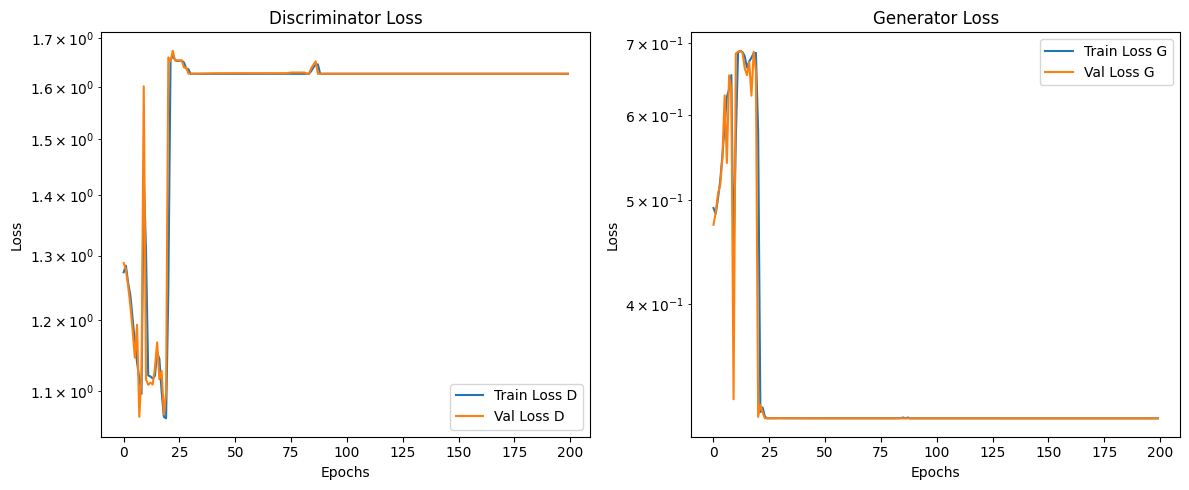

In [57]:
# Plot Loss Functions
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses_D, label='Train Loss D')
ax[0].plot(val_losses_D, label='Val Loss D')
ax[0].set_title('Discriminator Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_yscale('log')  # Log scale for better visibility
ax[0].legend()

ax[1].plot(train_losses_G, label='Train Loss G')
ax[1].plot(val_losses_G, label='Val Loss G')
ax[1].set_title('Generator Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_yscale('log')  # Log scale for better visibility
ax[1].legend()
plt.tight_layout()
plt.show()


Generating sample data...
Generated 10 samples (first sample shown):
[10.290101   11.143067   11.588679   ...  0.46116996 -0.20424947
 -0.12368362]


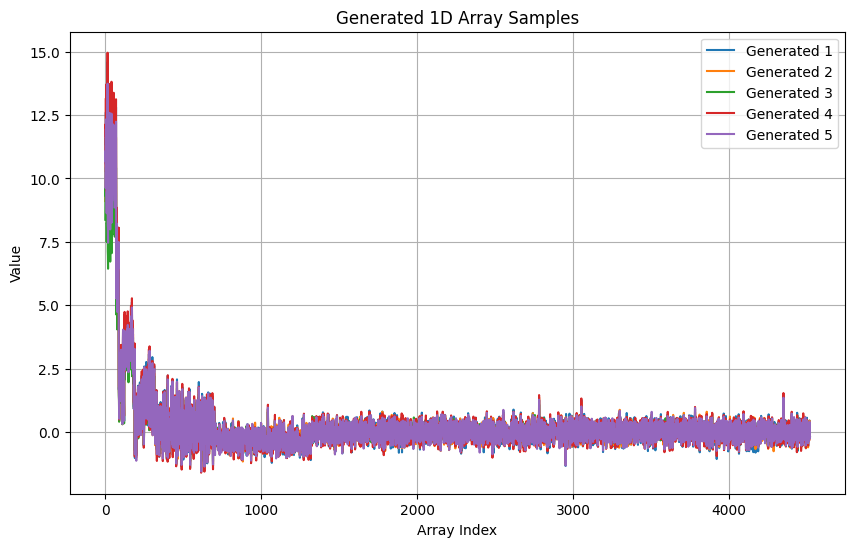

In [58]:
# --- Generate Sample Data ---
print("\nGenerating sample data...")
generator.eval() # Set generator to evaluation mode
with torch.no_grad(): # Disable gradient calculation
    noise = torch.randn(10, LATENT_DIM).to(device) # Generate 10 samples
    generated_samples = generator(noise).cpu().numpy()

print(f"Generated {len(generated_samples)} samples (first sample shown):")
print(generated_samples[0])

# --- Optional: Visualize samples ---
plt.figure(figsize=(10, 6))
for i in range(min(5, len(generated_samples))): # Plot first 5 generated samples
    plt.plot(generated_samples[i], label=f'Generated {i+1}')
plt.title('Generated 1D Array Samples')
plt.xlabel('Array Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()
